# Semantic chunking and Hybrid RAG

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [2]:
!pip install faiss-gpu-cu11

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Download Datasets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sentence_transformers import SentenceTransformer
import json
import os
import zipfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [2]:
zip_path = '/content/QMSum.zip'
extract_path = '/content/QMSum'

In [3]:
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")

Extraction completed.


In [4]:
QMSum_path = '/content/QMSum/QMSum'

In [5]:
files = {
    "train": [],
    "val": [],
    "test": []
}

for split in files.keys():
    for file in os.listdir(f"{QMSum_path}/data/ALL/{split}"):
        if file.endswith(".json"):
            files[split].append(f"{QMSum_path}/data/ALL/{split}/{file}")

# Semantic Chunking Datasets

In [11]:
!pip install faiss-gpu-cu11
!pip install semchunk
!pip install tiktoken transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.0 MB/s eta 0:00:00


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import Dict, List, Tuple
import scipy.sparse as sp
import semchunk

In [65]:
class SemEmbDatasets(Dataset):
    def __init__(self, json_files: List[str], encoder, chunker):
        self.data = []  # store each example here
        self.encoder = encoder
        self.chunker = chunker

        for json_file in json_files:
            file_info = self._load_json(json_file)
            self.data.append(file_info)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{i} {t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]
        utterances_chunks = self.chunker("\n".join(utterances))
        embedded_chunks = {}
        sentence_ind = 0
        for chunk in utterances_chunks:
          chunk_len = len(chunk.split("\n"))
          emb = self.encoder.encode(chunk, convert_to_numpy=True, normalize_embeddings=True)
          emb = np.ascontiguousarray(emb.reshape(1, -1), dtype='float32')
          embedded_chunks[(sentence_ind, sentence_ind + chunk_len)] = emb
          sentence_ind += chunk_len

        questions = []

        for item in data['specific_query_list']:
            query = item['query']
            embedded_query = self.encoder.encode(query, convert_to_numpy=True, normalize_embeddings=True)
            embedded_query = np.ascontiguousarray(embedded_query.reshape(1, -1), dtype='float32')

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)

            relevant_sentence = [utt for utt, label in zip(utterances, labels) if label == 1.0]

            questions.append({
                'query': query,
                'embedded_query': embedded_query,
                'labels': labels,
            })

        file_info = {
            "utterances": utterances,
            "utterances_chunks": utterances_chunks,
            "embedded_chunks": embedded_chunks,
            "questions": questions
        }
        return file_info

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'utterances': item['utterances'],
            'utterances_chunks': item['utterances_chunks'],
            'embedded_chunks': item['embedded_chunks'],
            'questions': item['questions']
        }

In [75]:
def load_datasets(files, encoder, chunker):
  print("Datasets are loading...")
  train_dataset = SemEmbDatasets(files['train'], encoder, chunker)
  val_dataset = SemEmbDatasets(files['val'], encoder, chunker)
  test_dataset = SemEmbDatasets(files['test'], encoder, chunker)

  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Validation dataset size: {len(val_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")
  return train_dataset, val_dataset, test_dataset

# Hybrid RAG
Dense retrieval (co-sine similarity) + BM25

In [22]:
!pip install rank_bm25

In [67]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc
from tqdm import tqdm
from typing import Dict, List, Tuple, Set
from rank_bm25 import BM25Okapi


class HybridRAG:
    def __init__(self):
        self.alpha = 0.5  # Default value, will be tuned
        self.threshold = 0.5  # Default value, will be tuned using EER

    def semantic_search(self, query_embedding: np.ndarray, chunk_embeddings: Dict[Tuple[int, int], np.ndarray]) -> Dict[Tuple[int, int], float]:
        """
        Perform semantic search using cosine similarity

        Args:
            query_embedding: Embedding of the query
            chunk_embeddings: Dictionary of chunk embeddings {(start_idx, end_idx): embedding}

        Returns:
            Dictionary of chunks and their semantic scores {(start_idx, end_idx): score}
        """
        scores = {}
        for chunk_range, chunk_emb in chunk_embeddings.items():
            # Compute cosine similarity
            score = np.dot(query_embedding, chunk_emb.T)[0][0]
            scores[chunk_range] = float(score)
        return scores

    def bm25_search(self, query: str, utterances_chunks: List[str]) -> Dict[int, float]:
        """
        Perform BM25 search on chunks

        Args:
            query: Query string
            utterances_chunks: List of utterance chunks

        Returns:
            Dictionary of chunk indices and their BM25 scores {idx: score}
        """

        # Tokenize utterance chunks
        tokenized_chunks = [chunk.lower().split() for chunk in utterances_chunks]
        bm25 = BM25Okapi(tokenized_chunks)

        # Tokenize query
        tokenized_query = query.lower().split()

        # Get BM25 scores
        bm25_scores = bm25.get_scores(tokenized_query)

        # Normalize scores to [0, 1]
        if np.max(bm25_scores) > 0:
            bm25_scores = bm25_scores / np.max(bm25_scores)

        return {i: score for i, score in enumerate(bm25_scores)}

    def hybrid_search(self, query: str, query_embedding: np.ndarray,
                     utterances: List[str], utterances_chunks: List[str],
                     chunk_embeddings: Dict[Tuple[int, int], np.ndarray]) -> Dict[Tuple[int, int], float]:
        """
        Perform hybrid search combining semantic and BM25 scores at chunk level

        Args:
            query: Query string
            query_embedding: Embedding of the query
            utterances: List of utterances (needed for mapping to utterance level later)
            utterances_chunks: List of utterance chunks
            chunk_embeddings: Dictionary of chunk embeddings

        Returns:
            Dictionary of chunk ranges and their hybrid scores {(start_idx, end_idx): score}
        """
        # Get semantic scores for chunks
        semantic_scores = self.semantic_search(query_embedding, chunk_embeddings)

        # Get BM25 scores for chunks
        bm25_scores = self.bm25_search(query, utterances_chunks)

        # Combine scores at chunk level
        hybrid_chunk_scores = {}

        for i, (chunk_range, semantic_score) in enumerate(semantic_scores.items()):
            if i in bm25_scores:
                bm25_score = bm25_scores[i]
                # Combine using alpha
                hybrid_score = self.alpha * semantic_score + (1 - self.alpha) * bm25_score
                hybrid_chunk_scores[chunk_range] = hybrid_score
            else:
                hybrid_chunk_scores[chunk_range] = self.alpha * semantic_score

        return hybrid_chunk_scores

    def predict(self, query: str, query_embedding: np.ndarray,
               utterances: List[str], utterances_chunks: List[str],
               chunk_embeddings: Dict[Tuple[int, int], np.ndarray]) -> List[int]:
        """
        Predict relevant utterances for a query by first scoring at chunk level
        and then mapping to utterance level

        Args:
            query: Query string
            query_embedding: Embedding of the query
            utterances: List of utterances
            utterances_chunks: List of utterance chunks
            chunk_embeddings: Dictionary of chunk embeddings

        Returns:
            Binary predictions for each utterance (1 for relevant, 0 for irrelevant)
        """
        # Get hybrid scores at chunk level
        chunk_scores = self.hybrid_search(query, query_embedding, utterances, utterances_chunks, chunk_embeddings)

        # Initialize scores for each utterance
        utterance_scores = np.zeros(len(utterances))

        # Map chunk scores to utterance level (each utterance gets max score from chunks it appears in)
        for chunk_range, score in chunk_scores.items():
            start_idx, end_idx = chunk_range
            for i in range(start_idx, end_idx):
                if i < len(utterances):
                    utterance_scores[i] = max(utterance_scores[i], score)

        # Apply threshold for prediction
        predictions = (utterance_scores >= self.threshold).astype(int)
        return predictions

    def compute_metrics(self, predictions: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
        """
        Compute evaluation metrics

        Args:
            predictions: Binary predictions (1 for relevant, 0 for irrelevant)
            labels: Ground truth labels

        Returns:
            Dictionary of metrics
        """
        # Convert to numpy arrays if needed
        if isinstance(predictions, torch.Tensor):
            predictions = predictions.cpu().numpy()
        if isinstance(labels, torch.Tensor):
            labels = labels.cpu().numpy()

        # Calculate precision, recall, F1
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)

        # Calculate accuracy
        accuracy = accuracy_score(labels, predictions)

        # Calculate IoU (Intersection over Union)
        intersection = np.logical_and(predictions, labels).sum()
        union = np.logical_or(predictions, labels).sum()
        iou = intersection / union if union > 0 else 0.0

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'iou': iou
        }

    def find_eer_threshold(self, scores: np.ndarray, labels: np.ndarray) -> float:
        """
        Find the threshold at the Equal Error Rate (EER) point

        Args:
            scores: Prediction scores
            labels: Ground truth labels

        Returns:
            Threshold at EER
        """
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(labels, scores)

        # Find the threshold where FPR ≈ 1-TPR (i.e., FAR ≈ FRR)
        fnr = 1 - tpr  # False Negative Rate
        abs_diff = np.abs(fpr - fnr)
        eer_idx = np.argmin(abs_diff)
        eer_threshold = thresholds[eer_idx]

        return float(eer_threshold)

    def tune_alpha(self, train_dataset, val_dataset, alpha_range=None) -> float:
        """
        Tune the alpha parameter using validation set

        Args:
            train_dataset: Training dataset
            val_dataset: Validation dataset
            alpha_range: Range of alpha values to try

        Returns:
            Best alpha value
        """
        if alpha_range is None:
            alpha_range = np.arange(0, 1.1, 0.1)

        best_alpha = 0
        best_f1 = 0

        print("Tuning alpha parameter...")

        for alpha in tqdm(alpha_range):
            self.alpha = alpha

            # Collect scores and labels from validation set
            all_scores = []
            all_labels = []

            for idx in range(len(val_dataset)):
                item = val_dataset[idx]
                utterances = item['utterances']
                utterances_chunks = item['utterances_chunks']
                embedded_chunks = item['embedded_chunks']

                for question in item['questions']:
                    query = question['query']
                    query_embedding = question['embedded_query']
                    labels = question['labels']

                    # Get hybrid scores at chunk level and map to utterance level
                    chunk_scores = self.hybrid_search(query, query_embedding, utterances, utterances_chunks, embedded_chunks)

                    # Map chunk scores to utterance level
                    utterance_scores = np.zeros(len(utterances))
                    for chunk_range, score in chunk_scores.items():
                        start_idx, end_idx = chunk_range
                        for i in range(start_idx, end_idx):
                            if i < len(utterances):
                                utterance_scores[i] = max(utterance_scores[i], score)

                    all_scores.extend(utterance_scores)
                    all_labels.extend(labels.cpu().numpy())

            # Find EER threshold
            self.threshold = self.find_eer_threshold(np.array(all_scores), np.array(all_labels))

            # Evaluate with this alpha and threshold
            val_metrics = self.evaluate(val_dataset)
            avg_f1 = np.mean([q_metrics['f1'] for q_metrics in val_metrics])

            print(f"Alpha: {alpha:.1f}, Threshold: {self.threshold:.4f}, Avg F1: {avg_f1:.4f}")

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_alpha = alpha

        # Set the best alpha
        self.alpha = best_alpha
        print(f"Best alpha: {best_alpha:.2f}")

        return best_alpha

    def find_optimal_threshold(self, dataset) -> float:
        """
        Find the optimal threshold using EER on the dataset

        Args:
            dataset: Dataset to use for finding threshold

        Returns:
            Optimal threshold
        """
        all_scores = []
        all_labels = []

        print("Finding optimal threshold...")

        for idx in tqdm(range(len(dataset))):
            item = dataset[idx]
            utterances = item['utterances']
            utterances_chunks = item['utterances_chunks']
            embedded_chunks = item['embedded_chunks']

            for question in item['questions']:
                query = question['query']
                query_embedding = question['embedded_query']
                labels = question['labels']

                # Get hybrid scores at chunk level
                chunk_scores = self.hybrid_search(query, query_embedding, utterances, utterances_chunks, embedded_chunks)

                # Map chunk scores to utterance level
                utterance_scores = np.zeros(len(utterances))
                for chunk_range, score in chunk_scores.items():
                    start_idx, end_idx = chunk_range
                    for i in range(start_idx, end_idx):
                        if i < len(utterances):
                            utterance_scores[i] = max(utterance_scores[i], score)

                all_scores.extend(utterance_scores)
                all_labels.extend(labels.cpu().numpy())

        # Find EER threshold
        threshold = self.find_eer_threshold(np.array(all_scores), np.array(all_labels))
        self.threshold = threshold

        print(f"Optimal threshold (EER): {threshold:.4f}")

        return threshold

    def evaluate(self, dataset) -> List[Dict[str, float]]:
        """
        Evaluate the model on a dataset

        Args:
            dataset: Dataset to evaluate on

        Returns:
            List of metrics for each question
        """
        all_metrics = []

        for idx in range(len(dataset)):
            item = dataset[idx]
            utterances = item['utterances']
            utterances_chunks = item['utterances_chunks']
            embedded_chunks = item['embedded_chunks']

            for question in item['questions']:
                query = question['query']
                query_embedding = question['embedded_query']
                labels = question['labels']

                # Make predictions at utterance level
                predictions = self.predict(query, query_embedding, utterances, utterances_chunks, embedded_chunks)

                # Compute metrics
                metrics = self.compute_metrics(predictions, labels)
                all_metrics.append(metrics)

        return all_metrics

    def display_aggregate_metrics(self, metrics_list: List[Dict[str, float]]) -> Dict[str, float]:
        """
        Display aggregate metrics

        Args:
            metrics_list: List of metrics dictionaries

        Returns:
            Dictionary of average metrics
        """
        avg_metrics = {
            'precision': np.mean([m['precision'] for m in metrics_list]),
            'recall': np.mean([m['recall'] for m in metrics_list]),
            'f1': np.mean([m['f1'] for m in metrics_list]),
            'accuracy': np.mean([m['accuracy'] for m in metrics_list]),
            'iou': np.mean([m['iou'] for m in metrics_list])
        }

        print("\nAggregate Metrics:")
        print(f"Precision: {avg_metrics['precision']:.4f}")
        print(f"Recall: {avg_metrics['recall']:.4f}")
        print(f"F1 Score: {avg_metrics['f1']:.4f}")
        print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
        print(f"IoU: {avg_metrics['iou']:.4f}")

        return avg_metrics

    def plot_precision_recall_curve(self, dataset):
        """
        Plot precision-recall curve for the dataset

        Args:
            dataset: Dataset to plot for
        """
        from sklearn.metrics import precision_recall_curve

        all_scores = []
        all_labels = []

        for idx in range(len(dataset)):
            item = dataset[idx]
            utterances = item['utterances']
            utterances_chunks = item['utterances_chunks']
            embedded_chunks = item['embedded_chunks']

            for question in item['questions']:
                query = question['query']
                query_embedding = question['embedded_query']
                labels = question['labels']

                # Get hybrid scores at chunk level
                chunk_scores = self.hybrid_search(query, query_embedding, utterances, utterances_chunks, embedded_chunks)

                # Map chunk scores to utterance level
                utterance_scores = np.zeros(len(utterances))
                for chunk_range, score in chunk_scores.items():
                    start_idx, end_idx = chunk_range
                    for i in range(start_idx, end_idx):
                        if i < len(utterances):
                            utterance_scores[i] = max(utterance_scores[i], score)

                all_scores.extend(utterance_scores)
                all_labels.extend(labels.cpu().numpy())

        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)

        # Plot
        plt.figure(figsize=(10, 7))
        plt.plot(recall, precision, 'b-', label=f'Precision-Recall (α={self.alpha:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        plt.legend()

        # Mark the EER threshold point
        eer_threshold = self.threshold
        # Find the closest threshold in the thresholds array
        if len(thresholds) > 0:
            idx = np.argmin(np.abs(thresholds - eer_threshold))
            if idx < len(precision) and idx < len(recall):
                plt.plot(recall[idx], precision[idx], 'ro', label=f'EER Threshold: {eer_threshold:.4f}')
                plt.legend()

        plt.show()


def run_hybrid_rag_pipeline(train_dataset, val_dataset, test_dataset):
    """
    Run the complete hybrid RAG pipeline

    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
    """
    # Initialize the model
    hybrid_rag = HybridRAG()

    # Step 1: Tune alpha parameter on train + validation
    best_alpha = hybrid_rag.tune_alpha(train_dataset, val_dataset)

    # Step 2: Find optimal threshold using EER on validation set
    optimal_threshold = hybrid_rag.find_optimal_threshold(val_dataset)

    # Step 3: Evaluate on test set
    print("\nEvaluating on test set...")
    test_metrics = hybrid_rag.evaluate(test_dataset)

    # Display aggregate metrics
    print("\nTest Set Results:")
    avg_test_metrics = hybrid_rag.display_aggregate_metrics(test_metrics)

    # Plot precision-recall curve
    hybrid_rag.plot_precision_recall_curve(test_dataset)

    return hybrid_rag, avg_test_metrics

## One run

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = SentenceTransformer('all-MiniLM-L6-v2').to(device)

In [68]:
chunker = semchunk.chunkerify('gpt-4', chunk_size=200)
train_dataset, val_dataset, test_dataset = load_datasets(files, encoder, chunker)

Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35


Tuning alpha parameter...


  9%|▉         | 1/11 [00:04<00:42,  4.20s/it]

Alpha: 0.0, Threshold: 0.3887, Avg F1: 0.1610


 18%|█▊        | 2/11 [00:07<00:32,  3.59s/it]

Alpha: 0.1, Threshold: 0.3714, Avg F1: 0.1628


 27%|██▋       | 3/11 [00:10<00:26,  3.37s/it]

Alpha: 0.2, Threshold: 0.3533, Avg F1: 0.1663


 36%|███▋      | 4/11 [00:14<00:24,  3.53s/it]

Alpha: 0.3, Threshold: 0.3380, Avg F1: 0.1685


 45%|████▌     | 5/11 [00:17<00:20,  3.45s/it]

Alpha: 0.4, Threshold: 0.3205, Avg F1: 0.1697


 55%|█████▍    | 6/11 [00:20<00:16,  3.34s/it]

Alpha: 0.5, Threshold: 0.3058, Avg F1: 0.1748


 64%|██████▎   | 7/11 [00:24<00:13,  3.46s/it]

Alpha: 0.6, Threshold: 0.2912, Avg F1: 0.1783


 73%|███████▎  | 8/11 [00:30<00:13,  4.38s/it]

Alpha: 0.7, Threshold: 0.2775, Avg F1: 0.1882


 82%|████████▏ | 9/11 [00:37<00:10,  5.14s/it]

Alpha: 0.8, Threshold: 0.2627, Avg F1: 0.1935


 91%|█████████ | 10/11 [00:43<00:05,  5.51s/it]

Alpha: 0.9, Threshold: 0.2486, Avg F1: 0.1952


100%|██████████| 11/11 [00:47<00:00,  4.27s/it]


Alpha: 1.0, Threshold: 0.2347, Avg F1: 0.1945
Best alpha: 0.90
Finding optimal threshold...


100%|██████████| 35/35 [00:01<00:00, 26.63it/s]


Optimal threshold (EER): 0.2486

Evaluating on test set...

Test Set Results:

Aggregate Metrics:
Precision: 0.1618
Recall: 0.6806
F1 Score: 0.2063
Accuracy: 0.5503
IoU: 0.1274


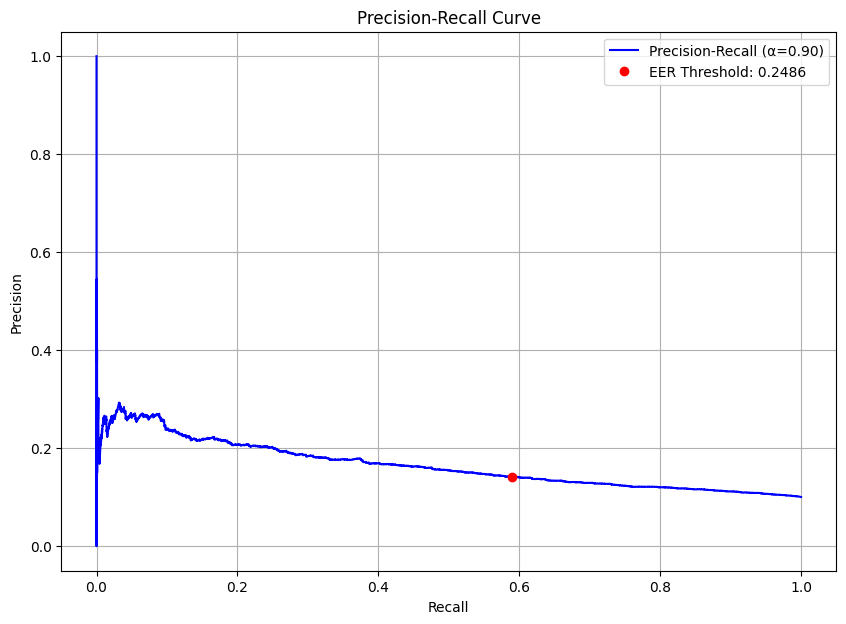


Best alpha: 0.90
Optimal threshold: 0.2486
Test F1 score: 0.2063


In [69]:
hybrid_rag, test_metrics = run_hybrid_rag_pipeline(train_dataset, val_dataset, test_dataset)

print(f"\nBest alpha: {hybrid_rag.alpha:.2f}")
print(f"Optimal threshold: {hybrid_rag.threshold:.4f}")
print(f"Test F1 score: {test_metrics['f1']:.4f}")

## Many runs

In [93]:
def chunk_size_analysis(encoder, chunk_sizes):
    results = {
        'chunk_size': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'iou': [],
        'alpha': [],
        'threshold': []
    }

    for chunk_size in chunk_sizes:
        chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)
        train_dataset, val_dataset, test_dataset = load_datasets(files, encoder, chunker)
        hybrid_rag, test_metrics = run_hybrid_rag_pipeline(train_dataset, val_dataset, test_dataset)

        results['chunk_size'].append(chunk_size)
        results['precision'].append(test_metrics['precision'])
        results['recall'].append(test_metrics['recall'])
        results['f1'].append(test_metrics['f1'])
        results['accuracy'].append(test_metrics['accuracy'])
        results['iou'].append(test_metrics['iou'])
        results['alpha'].append(hybrid_rag.alpha)
        results['threshold'].append(hybrid_rag.threshold)

        print(f"\nChunk size: {chunk_size}")
        print(f"Best alpha: {hybrid_rag.alpha:.2f}")
        print(f"Optimal threshold: {hybrid_rag.threshold:.4f}")
        print(f"Test F1 score: {test_metrics['f1']:.4f}")

    # Plotting: Grouped Bar Chart
    metrics = ['recall', 'precision', 'f1', 'accuracy', 'iou']
    num_metrics = len(metrics)
    num_chunks = len(results['chunk_size'])

    x = np.arange(num_chunks)  # x locations for groups
    bar_width = 0.15

    plt.figure(figsize=(14, 6))

    for i, metric in enumerate(metrics):
        offsets = x + (i - num_metrics / 2) * bar_width + bar_width / 2
        plt.bar(offsets, results[metric], width=bar_width, label=metric)

        # Optional: annotate each bar with its value
        for j, val in enumerate(results[metric]):
            plt.text(offsets[j], val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    plt.xlabel('Chunk Size')
    plt.ylabel('Metric Score')
    plt.title('Hybrid RAG Performance Metrics per Chunk Size')
    plt.xticks(x, results['chunk_size'])
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    return results


Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35
Tuning alpha parameter...


  9%|▉         | 1/11 [00:03<00:36,  3.67s/it]

Alpha: 0.0, Threshold: 0.3011, Avg F1: 0.1499


 18%|█▊        | 2/11 [00:07<00:33,  3.67s/it]

Alpha: 0.1, Threshold: 0.2921, Avg F1: 0.1519


 27%|██▋       | 3/11 [00:10<00:27,  3.49s/it]

Alpha: 0.2, Threshold: 0.2836, Avg F1: 0.1529


 36%|███▋      | 4/11 [00:13<00:23,  3.39s/it]

Alpha: 0.3, Threshold: 0.2761, Avg F1: 0.1544


 45%|████▌     | 5/11 [00:17<00:21,  3.64s/it]

Alpha: 0.4, Threshold: 0.2685, Avg F1: 0.1585


 55%|█████▍    | 6/11 [00:21<00:17,  3.49s/it]

Alpha: 0.5, Threshold: 0.2604, Avg F1: 0.1633


 64%|██████▎   | 7/11 [00:24<00:13,  3.41s/it]

Alpha: 0.6, Threshold: 0.2517, Avg F1: 0.1656


 73%|███████▎  | 8/11 [00:27<00:10,  3.47s/it]

Alpha: 0.7, Threshold: 0.2429, Avg F1: 0.1686


 82%|████████▏ | 9/11 [00:31<00:07,  3.55s/it]

Alpha: 0.8, Threshold: 0.2364, Avg F1: 0.1754


 91%|█████████ | 10/11 [00:34<00:03,  3.45s/it]

Alpha: 0.9, Threshold: 0.2288, Avg F1: 0.1712


100%|██████████| 11/11 [00:38<00:00,  3.47s/it]


Alpha: 1.0, Threshold: 0.2228, Avg F1: 0.1700
Best alpha: 0.80
Finding optimal threshold...


100%|██████████| 35/35 [00:01<00:00, 21.82it/s]


Optimal threshold (EER): 0.2364

Evaluating on test set...

Test Set Results:

Aggregate Metrics:
Precision: 0.1370
Recall: 0.6268
F1 Score: 0.1831
Accuracy: 0.5295
IoU: 0.1110


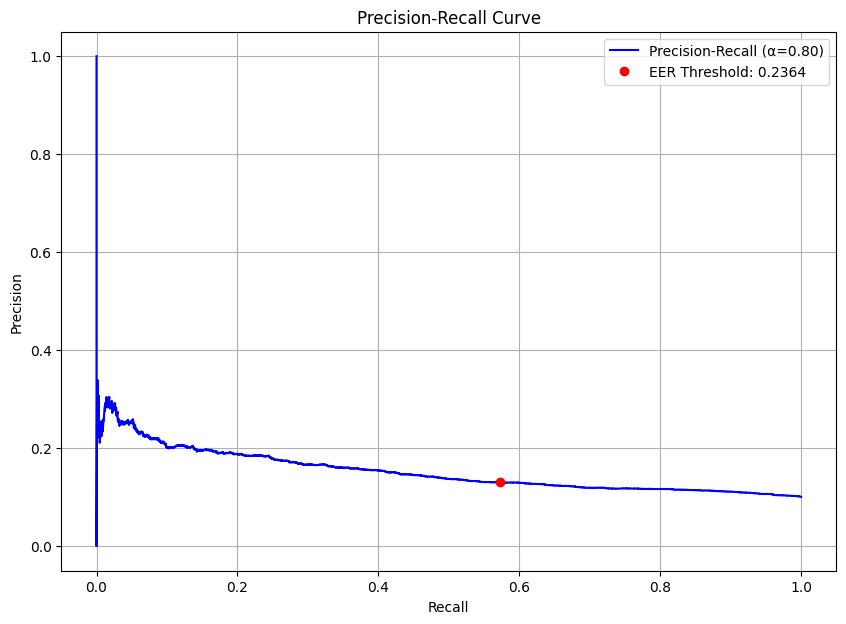


Chunk size: 128
Best alpha: 0.80
Optimal threshold: 0.2364
Test F1 score: 0.1831
Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35
Tuning alpha parameter...


  9%|▉         | 1/11 [00:03<00:33,  3.32s/it]

Alpha: 0.0, Threshold: 0.5397, Avg F1: 0.1987


 18%|█▊        | 2/11 [00:06<00:30,  3.34s/it]

Alpha: 0.1, Threshold: 0.5077, Avg F1: 0.1990


 27%|██▋       | 3/11 [00:09<00:25,  3.15s/it]

Alpha: 0.2, Threshold: 0.4778, Avg F1: 0.2011


 36%|███▋      | 4/11 [00:12<00:21,  3.04s/it]

Alpha: 0.3, Threshold: 0.4503, Avg F1: 0.2038


 45%|████▌     | 5/11 [00:15<00:19,  3.19s/it]

Alpha: 0.4, Threshold: 0.4219, Avg F1: 0.2069


 55%|█████▍    | 6/11 [00:19<00:15,  3.18s/it]

Alpha: 0.5, Threshold: 0.3920, Avg F1: 0.2081


 64%|██████▎   | 7/11 [00:22<00:12,  3.09s/it]

Alpha: 0.6, Threshold: 0.3629, Avg F1: 0.2117


 73%|███████▎  | 8/11 [00:24<00:09,  3.04s/it]

Alpha: 0.7, Threshold: 0.3300, Avg F1: 0.2127


 82%|████████▏ | 9/11 [00:28<00:06,  3.24s/it]

Alpha: 0.8, Threshold: 0.2993, Avg F1: 0.2139


 91%|█████████ | 10/11 [00:31<00:03,  3.16s/it]

Alpha: 0.9, Threshold: 0.2677, Avg F1: 0.2080


100%|██████████| 11/11 [00:34<00:00,  3.14s/it]


Alpha: 1.0, Threshold: 0.2383, Avg F1: 0.2032
Best alpha: 0.80
Finding optimal threshold...


100%|██████████| 35/35 [00:01<00:00, 29.01it/s]


Optimal threshold (EER): 0.2993

Evaluating on test set...

Test Set Results:

Aggregate Metrics:
Precision: 0.1717
Recall: 0.7660
F1 Score: 0.2240
Accuracy: 0.5564
IoU: 0.1397


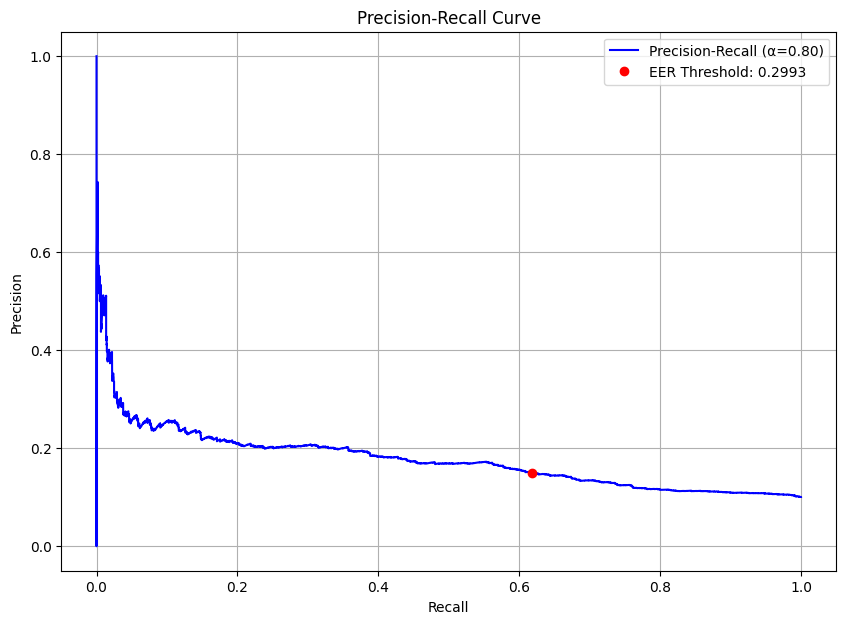


Chunk size: 512
Best alpha: 0.80
Optimal threshold: 0.2993
Test F1 score: 0.2240
Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35
Tuning alpha parameter...


  9%|▉         | 1/11 [00:02<00:28,  2.82s/it]

Alpha: 0.0, Threshold: 0.6336, Avg F1: 0.2007


 18%|█▊        | 2/11 [00:06<00:29,  3.30s/it]

Alpha: 0.1, Threshold: 0.5955, Avg F1: 0.2024


 27%|██▋       | 3/11 [00:09<00:24,  3.09s/it]

Alpha: 0.2, Threshold: 0.5566, Avg F1: 0.2073


 36%|███▋      | 4/11 [00:12<00:20,  2.97s/it]

Alpha: 0.3, Threshold: 0.5162, Avg F1: 0.2068


 45%|████▌     | 5/11 [00:14<00:17,  2.90s/it]

Alpha: 0.4, Threshold: 0.4801, Avg F1: 0.2101


 55%|█████▍    | 6/11 [00:18<00:15,  3.14s/it]

Alpha: 0.5, Threshold: 0.4434, Avg F1: 0.2142


 64%|██████▎   | 7/11 [00:21<00:12,  3.01s/it]

Alpha: 0.6, Threshold: 0.4024, Avg F1: 0.2110


 73%|███████▎  | 8/11 [00:23<00:08,  2.94s/it]

Alpha: 0.7, Threshold: 0.3589, Avg F1: 0.2125


 82%|████████▏ | 9/11 [00:26<00:05,  2.88s/it]

Alpha: 0.8, Threshold: 0.3174, Avg F1: 0.2021


 91%|█████████ | 10/11 [00:30<00:03,  3.11s/it]

Alpha: 0.9, Threshold: 0.2795, Avg F1: 0.1916


100%|██████████| 11/11 [00:33<00:00,  3.01s/it]


Alpha: 1.0, Threshold: 0.2378, Avg F1: 0.1828
Best alpha: 0.50
Finding optimal threshold...


100%|██████████| 35/35 [00:01<00:00, 29.97it/s]


Optimal threshold (EER): 0.4434

Evaluating on test set...

Test Set Results:

Aggregate Metrics:
Precision: 0.1801
Recall: 0.7485
F1 Score: 0.2311
Accuracy: 0.5558
IoU: 0.1493


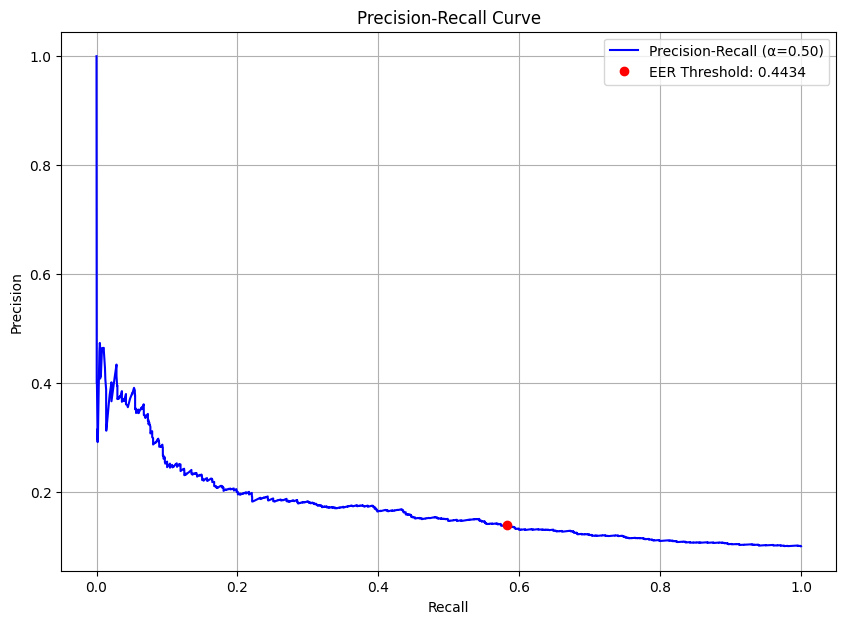


Chunk size: 1024
Best alpha: 0.50
Optimal threshold: 0.4434
Test F1 score: 0.2311
Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35
Tuning alpha parameter...


  9%|▉         | 1/11 [00:02<00:26,  2.68s/it]

Alpha: 0.0, Threshold: 0.7268, Avg F1: 0.1974


 18%|█▊        | 2/11 [00:05<00:24,  2.71s/it]

Alpha: 0.1, Threshold: 0.6757, Avg F1: 0.1946


 27%|██▋       | 3/11 [00:09<00:24,  3.12s/it]

Alpha: 0.2, Threshold: 0.6249, Avg F1: 0.1945


 36%|███▋      | 4/11 [00:11<00:20,  2.94s/it]

Alpha: 0.3, Threshold: 0.5807, Avg F1: 0.1953


 45%|████▌     | 5/11 [00:14<00:17,  2.85s/it]

Alpha: 0.4, Threshold: 0.5326, Avg F1: 0.1937


 55%|█████▍    | 6/11 [00:17<00:13,  2.79s/it]

Alpha: 0.5, Threshold: 0.4828, Avg F1: 0.1966


 64%|██████▎   | 7/11 [00:20<00:12,  3.03s/it]

Alpha: 0.6, Threshold: 0.4345, Avg F1: 0.1913


 73%|███████▎  | 8/11 [00:23<00:08,  2.92s/it]

Alpha: 0.7, Threshold: 0.3821, Avg F1: 0.1892


 82%|████████▏ | 9/11 [00:25<00:05,  2.85s/it]

Alpha: 0.8, Threshold: 0.3287, Avg F1: 0.1762


 91%|█████████ | 10/11 [00:28<00:02,  2.80s/it]

Alpha: 0.9, Threshold: 0.2790, Avg F1: 0.1724


100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


Alpha: 1.0, Threshold: 0.2330, Avg F1: 0.1609
Best alpha: 0.00
Finding optimal threshold...


100%|██████████| 35/35 [00:01<00:00, 30.80it/s]


Optimal threshold (EER): 0.7268

Evaluating on test set...

Test Set Results:

Aggregate Metrics:
Precision: 0.1749
Recall: 0.7485
F1 Score: 0.2299
Accuracy: 0.5431
IoU: 0.1497


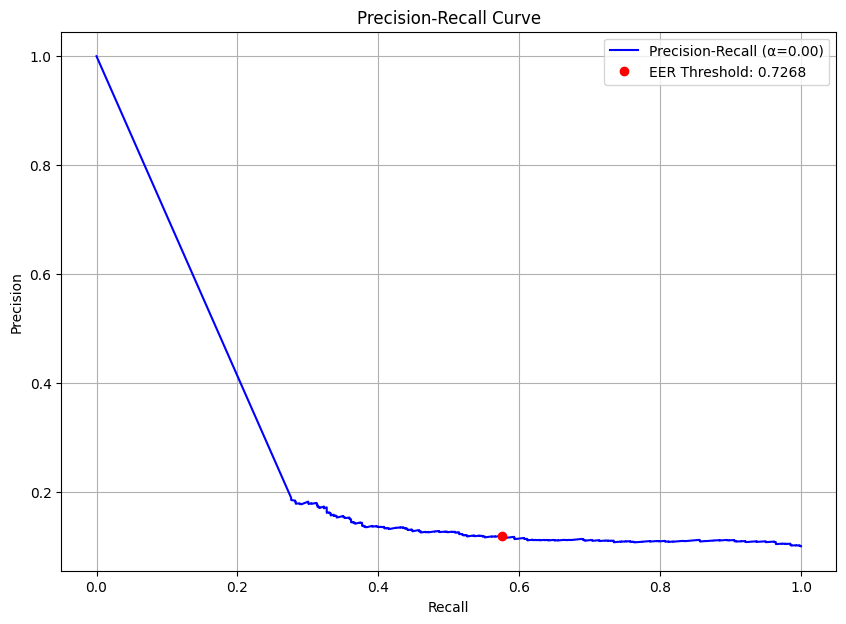


Chunk size: 2048
Best alpha: 0.00
Optimal threshold: 0.7268
Test F1 score: 0.2299


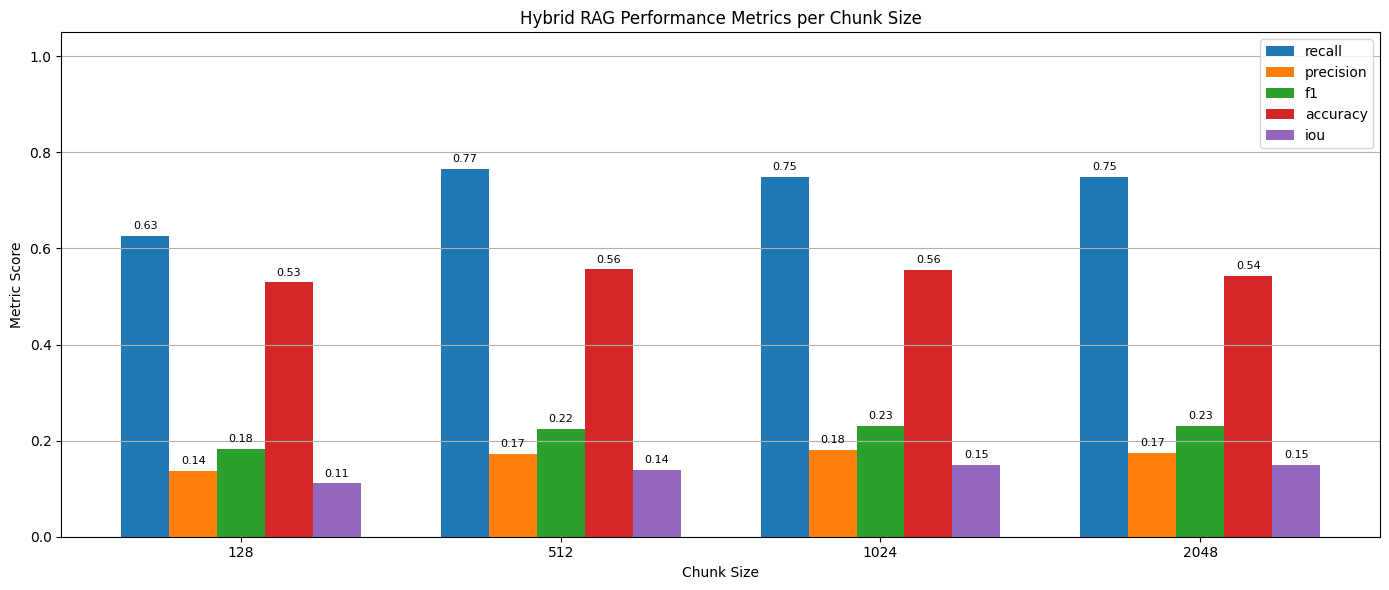

In [92]:
chunk_sizes = [128, 512, 1024, 2048]
results = chunk_size_analysis(encoder, chunk_sizes)